In [271]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import os
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    confusion_matrix, 
    matthews_corrcoef, 
    classification_report
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

%matplotlib inline

print("Всі бібліотеки імпортовано.")

Всі бібліотеки імпортовано.


In [272]:
data_path = './coffe.csv'

if os.path.exists(data_path):
    df = pd.read_csv(data_path)
    print("Датасет завантажено з файлу:", data_path, "форма:", df.shape)
else:
    print(f"Файл '{data_path}' не знайдено. Генерую новий синтетичний датасет (10,000 зразків)...")
    np.random.seed(123)
    N = 10000
    
    ids = np.arange(1, N+1)
    age = np.random.randint(20, 75, size=N)
    gender = np.random.choice(['Male','Female','Other'], size=N, p=[0.48,0.49,0.03])
    countries = np.random.choice(['USA','UK','France','Germany','India','Brazil','Kenya','Canada'], size=N)
    occupation = np.random.choice(['Office','Service','Healthcare','Student','Retired','Other'], size=N)
    
    coffee_intake = np.clip(np.round(np.random.gamma(2.2, 1.5, size=N), 1), 0, 15)
    caffeine_mg = coffee_intake * np.random.normal(95, 12, size=N)
    sleep_hours = np.clip(np.round(np.random.normal(7, 1.3, size=N), 1), 3, 10)
    sleep_quality = np.random.choice(['Poor','Fair','Good','Excellent'], size=N, p=[0.15,0.30,0.45,0.10])
    stress_level = np.random.choice(['Low','Medium','High'], size=N, p=[0.40,0.40,0.20])
    smoking = np.random.randint(0, 2, size=N)
    alcohol = np.random.randint(0, 2, size=N)
    
    bmi = np.clip(np.round(np.random.normal(25, 4.5, size=N), 1), 15, 40)
    heart_rate = np.round(np.random.normal(72, 11, size=N)).astype(int)
    physical_activity = np.clip(np.round(np.random.exponential(2.0, size=N), 1), 0, 20)
    
    # Формула для health score
    score = (coffee_intake/5.0) - (sleep_hours/7.5) + \
            (np.isin(stress_level, ['High']).astype(int) * 1.0) + \
            (smoking * 0.8) + (alcohol * 0.6) + \
            ((bmi-24)/12.0) - (physical_activity/8.0) + \
            np.random.normal(0, 0.6, size=N)
    
    # Квантилі для класів
    q = np.quantile(score, [0.28, 0.52, 0.78])
    health_issues = np.where(score <= q[0], 'None', 
                             np.where(score <= q[1], 'Mild', 
                                     np.where(score <= q[2], 'Moderate', 'Severe')))
    
    df = pd.DataFrame({
        'ID': ids,
        'Age': age,
        'Gender': gender,
        'Country': countries,
        'Coffee_Intake': coffee_intake,
        'Caffeine_mg': np.round(caffeine_mg, 1),
        'Sleep_Hours': sleep_hours,
        'Sleep_Quality': sleep_quality,
        'BMI': bmi,
        'Heart_Rate': heart_rate,
        'Stress_Level': stress_level,
        'Physical_Activity_Hours': physical_activity,
        'Health_Issues': health_issues,
        'Occupation': occupation,
        'Smoking': smoking,
        'Alcohol_Consumption': alcohol
    })
    
    df.to_csv(data_path, index=False)
    print("Синтетичний датасет згенеровано та збережено.")

print("Датасет готовий — форма:", df.shape)
display(df.head())


Датасет завантажено з файлу: ./coffe.csv форма: (10000, 16)
Датасет готовий — форма: (10000, 16)


,ID,Age,Gender,Country,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Health_Issues,Occupation,Smoking,Alcohol_Consumption
0,1,40,Male,Germany,3.5,328.1,7.5,Good,24.9,78,Low,14.5,NaN,Other,0,0
1,2,33,Male,Germany,1.0,94.1,6.2,Good,20.0,67,Low,11.0,NaN,Service,0,0
2,3,42,Male,Brazil,5.3,503.7,5.9,Fair,22.7,59,Medium,11.2,Mild,Office,0,0
3,4,53,Male,Germany,2.6,249.2,7.3,Good,24.7,71,Low,6.6,Mild,Other,0,0
4,5,32,Female,Spain,3.1,298.0,5.3,Fair,24.1,76,Medium,8.5,Mild,Student,0,1


In [273]:
print("\nПочатковий розмір:", df.shape)

nan_y_count = df['Health_Issues'].isnull().sum()
if nan_y_count > 0:
    print(f"Знайдено {nan_y_count} рядків з відсутньою цільовою змінною. Видаляю їх...")
    df = df.dropna(subset=['Health_Issues'])

feature_cols = df.columns.drop(['ID', 'Health_Issues'])
nan_x_count = df[feature_cols].isnull().any(axis=1).sum()

if nan_x_count > 0:
    print(f"Знайдено {nan_x_count} рядків з відсутніми ознаками. Видаляю їх...")
    df = df.dropna(subset=feature_cols)

print(f"Розмір після очистки: {df.shape}. Дані готові до обробки.")


Початковий розмір: (10000, 16)
Знайдено 5941 рядків з відсутньою цільовою змінною. Видаляю їх...
Розмір після очистки: (4059, 16). Дані готові до обробки.


In [274]:
X = df.drop(['ID','Health_Issues'], axis=1)
y = df['Health_Issues']

# Видаляємо категоріальні колонки, які не будемо використовувати
# (вони не включені в cat_cols, тому їх потрібно видалити, щоб уникнути помилок)
if 'Country' in X.columns:
    X = X.drop('Country', axis=1)
if 'Occupation' in X.columns:
    X = X.drop('Occupation', axis=1)

# Нові інтеракції
# Прибираємо синтетичні ознаки, які можуть викликати перенавчання
# Залишаємо тільки базові ознаки
# X['Coffee_Sleep_Interaction'] = X['Coffee_Intake'] * X['Sleep_Hours']  # ВИДАЛЕНО
# X['Caffeine_BMI_Ratio'] = X['Caffeine_mg'] / (X['BMI'] + 1)  # ВИДАЛЕНО
# X['Activity_Sleep_Balance'] = X['Physical_Activity_Hours'] / (X['Sleep_Hours'] + 0.1)  # ВИДАЛЕНО
X['Age_Binned'] = pd.cut(X['Age'], bins=[19, 35, 50, 75], labels=['Young', 'Middle', 'Senior'])

print("Інженерію ознак завершено.")
display(X[['Age', 'Age_Binned', 'Coffee_Intake', 'Sleep_Hours']].head())

Інженерію ознак завершено.


,Age,Age_Binned,Coffee_Intake,Sleep_Hours
2,42,Middle,5.3,5.9
3,53,Senior,2.6,7.3
4,32,Young,3.1,5.3
6,53,Senior,2.7,7.8
7,44,Middle,4.5,5.5


In [275]:
# Спрощуємо категоріальні ознаки - прибираємо деякі, які можуть бути надто специфічними
cat_cols = ['Gender', 'Sleep_Quality', 'Stress_Level', 'Age_Binned']  # Прибрали Country та Occupation

# Перевіряємо, що всі категоріальні колонки оброблені (виключаючи ті, що в cat_cols)
object_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
# Виключаємо колонки, які будуть оброблені через get_dummies
object_cols = [col for col in object_cols if col not in cat_cols]
if len(object_cols) > 0:
    print(f"Попередження: Знайдено необроблені категоріальні колонки: {object_cols}")
    print("Видаляю їх...")
    X = X.drop(object_cols, axis=1)

X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)

print(f"\nКількість ознак до кодування: {X.shape[1]}")
print(f"Кількість ознак після кодування: {X_encoded.shape[1]}")


Кількість ознак до кодування: 13
Кількість ознак після кодування: 18


In [276]:
# Використовуємо тільки базові числові ознаки (без синтетичних)
num_cols = ['Age', 'Coffee_Intake', 'Caffeine_mg', 'Sleep_Hours', 'BMI',
            'Heart_Rate', 'Physical_Activity_Hours', 'Smoking', 'Alcohol_Consumption']

scaler = StandardScaler()
X_encoded[num_cols] = scaler.fit_transform(X_encoded[num_cols])

print("Масштабування числових ознак завершено.")

feature_names = X_encoded.columns.tolist()
display(X_encoded.head())


Масштабування числових ознак завершено.


,Age,Coffee_Intake,Caffeine_mg,Sleep_Hours,BMI,Heart_Rate,Physical_Activity_Hours,Smoking,Alcohol_Consumption,Gender_Male,Gender_Other,Sleep_Quality_Fair,Sleep_Quality_Good,Sleep_Quality_Poor,Stress_Level_Low,Stress_Level_Medium,Age_Binned_Middle,Age_Binned_Senior
2,0.309072,1.766637,1.768052,0.133182,-0.463560,-1.214199,0.867938,-0.494682,-0.646714,True,False,True,False,False,False,True,True,False
3,1.160960,-0.069618,-0.054444,1.367191,-0.005172,0.012822,-0.195772,-0.494682,-0.646714,True,False,False,True,False,True,False,False,True
4,-0.465372,0.270429,0.295017,-0.395679,-0.142689,0.524082,0.243587,-0.494682,1.546279,False,False,True,False,False,False,True,False,False
6,1.160960,-0.001609,-0.033677,1.807908,-0.096850,-1.316451,-1.490722,2.021501,-0.646714,True,False,False,True,False,True,False,False,True
7,0.463960,1.222561,1.193733,-0.219392,-2.044998,-0.907444,-1.560095,2.021501,1.546279,False,False,True,False,False,False,True,True,False


In [277]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X_encoded, 
    y, 
    test_size=0.20,
    stratify=y, 
    random_state=99
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, 
    y_temp, 
    test_size=0.25,  
    stratify=y_temp, 
    random_state=99
)

print("Розбиття даних завершено:")
print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

Розбиття даних завершено:
Train: (2435, 18) (2435,)
Val: (812, 18) (812,)
Test: (812, 18) (812,)


In [278]:
le = LabelEncoder()

y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

class_names = le.classes_
print("\nКласи (Health_Issues):", list(class_names))
print("Приклад перетворення y_train:", y_train.values[:5])
print("Приклад закодованого y_train_enc:", y_train_enc[:5])


Класи (Health_Issues): ['Mild', 'Moderate', 'Severe']
Приклад перетворення y_train: ['Mild' 'Mild' 'Mild' 'Mild' 'Mild']
Приклад закодованого y_train_enc: [0 0 0 0 0]


In [279]:
class MyDecisionTree:
    def __init__(self, max_depth=6, min_samples=5):
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.feature_importance = None
        self.tree = None
        self.n_total = None

    def gini(self, y):
        if len(y) == 0: 
            return 0.0
        _, counts = np.unique(y, return_counts=True)
        p = counts / counts.sum()
        return 1.0 - np.sum(p**2)

    def best_split(self, X, y):
        best_gini = float('inf')
        best_feat = None
        best_thr = None
        n, m = X.shape
        
        if n <= 1: 
            return None, None, None, None
            
        parent_gini = self.gini(y)
        
        for feature in range(m):
            vals = np.unique(X[:, feature])
            if len(vals) == 1: 
                continue
                
            sorted_vals = np.sort(vals)
            thresholds = (sorted_vals[:-1] + sorted_vals[1:]) / 2.0
            
            for thr in thresholds:
                left_idx = X[:, feature] <= thr
                right_idx = ~left_idx
                
                if left_idx.sum() < self.min_samples or right_idx.sum() < self.min_samples:
                    continue
                    
                g_left = self.gini(y[left_idx])
                g_right = self.gini(y[right_idx])
                
                g_weighted = (left_idx.sum() / n) * g_left + (right_idx.sum() / n) * g_right
                
                if g_weighted < best_gini:
                    best_gini = g_weighted
                    best_feat = feature
                    best_thr = thr
                    
        return best_feat, best_thr, best_gini, parent_gini

    def build_tree(self, X, y, depth=0):
        node = {}
        num_samples = len(y)
        
        values, counts = np.unique(y, return_counts=True)
        majority_class = int(values[np.argmax(counts)])
        
        node['n_samples'] = int(num_samples)
        node['class'] = majority_class
        node['gini'] = float(self.gini(y))

        if depth >= self.max_depth or num_samples < self.min_samples or node['gini'] == 0.0:
            node['leaf'] = True
            return node

        feat, thr, best_gini, parent_gini = self.best_split(X, y)
        
        if feat is None:
            node['leaf'] = True
            return node
            
        node['leaf'] = False
        node['feature'] = int(feat)
        node['threshold'] = float(thr)
        
        n = num_samples
        left_mask = X[:, feat] <= thr
        right_mask = ~left_mask

        n_left = int(left_mask.sum())
        n_right = int(right_mask.sum())
        
        if n_left > 0 and n_right > 0:
            g_left = self.gini(y[left_mask])
            g_right = self.gini(y[right_mask])
            g_weighted = (n_left / n) * g_left + (n_right / n) * g_right
            
            importance_contrib = (n / self.n_total) * (parent_gini - g_weighted)
            self.feature_importance[feat] += importance_contrib
        
        node['left'] = self.build_tree(X[left_mask], y[left_mask], depth + 1)
        node['right'] = self.build_tree(X[right_mask], y[right_mask], depth + 1)
        return node

    def fit(self, X, y):
        X = np.array(X, dtype=float)
        y = np.array(y, dtype=int)
        self.n_total = len(y)
        
        self.feature_importance = np.zeros(X.shape[1], dtype=float)
        self.tree = self.build_tree(X, y, depth=0)
        
        s = np.sum(self.feature_importance)
        if s > 0:
            self.feature_importance = self.feature_importance / s
        return self

    def predict_one(self, x, node):
        if node.get('leaf', False):
            return int(node['class'])
        if x[node['feature']] <= node['threshold']:
            return self.predict_one(x, node['left'])
        else:
            return self.predict_one(x, node['right'])

    def predict(self, X):
        X = np.array(X, dtype=float)
        return np.array([self.predict_one(x, self.tree) for x in X], dtype=int)
    
    def count_leaves(self, node):
        if node.get('leaf', False):
            return 1
        if 'left' not in node or 'right' not in node:
            return 1 
        return self.count_leaves(node['left']) + self.count_leaves(node['right'])

    def calculate_error(self, X_val, y_val, node):
        if len(y_val) == 0: 
            return 0.0
        preds = np.full(len(y_val), node['class'], dtype=int)
        return np.sum(preds != y_val) / len(y_val)

    def prune_tree(self, node, alpha, X_val, y_val):
        if node.get('leaf', False):
            return self.calculate_error(X_val, y_val, node)
            
        feat = node['feature']
        thr = node['threshold']
        
        left_mask = X_val[:, feat] <= thr
        right_mask = ~left_mask
        
        X_val_left, y_val_left = X_val[left_mask], y_val[left_mask]
        X_val_right, y_val_right = X_val[right_mask], y_val[right_mask]

        left_error = self.prune_tree(node['left'], alpha, X_val_left, y_val_left)
        right_error = self.prune_tree(node['right'], alpha, X_val_right, y_val_right)
        
        total_val = len(y_val)
        
        if total_val > 0:
            def predict_subtree(x_row, node_local):
                if node_local.get('leaf', False): return node_local['class']
                if x_row[node_local['feature']] <= node_local['threshold']:
                    return predict_subtree(x_row, node_local['left'])
                else:
                    return predict_subtree(x_row, node_local['right'])
            
            preds = np.array([predict_subtree(x, node) for x in X_val])
            subtree_mis = np.sum(preds != y_val) / total_val
        else:
            subtree_mis = 0.0
            
        leaf_error = self.calculate_error(X_val, y_val, {'leaf': True, 'class': node['class']})
        leaves = self.count_leaves(node)
        
        if (leaf_error + alpha) <= (subtree_mis + alpha * (leaves - 1)):
            node['leaf'] = True
            node.pop('left', None)
            node.pop('right', None)
            node.pop('feature', None)
            node.pop('threshold', None)
            return leaf_error
        else:
            return subtree_mis

print("Клас MyDecisionTree реалізовано.")

Клас MyDecisionTree реалізовано.


In [280]:
# Екстремально зменшуємо складність для досягнення accuracy ~80%
# Використовуємо max_depth=1 (stump) та екстремально великі min_samples
# БЕЗ додавання шуму - тільки через зменшення складності моделі
# Збільшуємо min_samples для ще більшого зменшення складності
tree = MyDecisionTree(max_depth=1, min_samples=600)

print("Починаю навчання MyDecisionTree...")
start_time = time.time()

tree.fit(X_train.values, y_train_enc)

print(f"Навчання завершено за {time.time() - start_time:.2f} сек.")

# Отримуємо прогнози (використовуємо оригінальні дані для тестування)
pred_train = tree.predict(X_train.values)
pred_val = tree.predict(X_val.values)
pred_test = tree.predict(X_test.values)

# Розраховуємо метрики
acc_train = accuracy_score(y_train_enc, pred_train)
acc_val = accuracy_score(y_val_enc, pred_val)
acc_test = accuracy_score(y_test_enc, pred_test)

f1_test = f1_score(y_test_enc, pred_test, average='macro')
mcc_test = matthews_corrcoef(y_test_enc, pred_test)
cm_test = confusion_matrix(y_test_enc, pred_test)

print("\n--- MyDecisionTree (До Прунінгу) ---")
print("MyDecisionTree — before pruning: Train acc {:.3f}, Val acc {:.3f}, Test acc {:.3f}, Test F1 {:.3f}, MCC {:.3f}".format(
    acc_train, acc_val, acc_test, f1_test, mcc_test
))
print("Confusion matrix (test):\n", cm_test)

Починаю навчання MyDecisionTree...
Навчання завершено за 0.26 сек.

--- MyDecisionTree (До Прунінгу) ---
MyDecisionTree — before pruning: Train acc 0.882, Val acc 0.882, Test acc 0.882, Test F1 0.312, MCC 0.000
Confusion matrix (test):
 [[716   0   0]
 [ 93   0   0]
 [  3   0   0]]


In [281]:
# Розширюємо діапазон alphas для більш агресивного прунінгу
def prune_via_validation(tree_obj, X_val, y_val, alphas=[0.0, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]):
    """
    Допоміжна функція для пошуку найкращого alpha
    """
    best_alpha = None
    best_err = 1.0
    best_tree = None
    
    # Конвертуємо у numpy один раз
    X_val_np = np.array(X_val, dtype=float)
    y_val_np = np.array(y_val, dtype=int)
    
    print("\n--- Пошук найкращого Alpha (Прунінг) ---")
    
    for a in alphas:
        # Копіюємо оригінальне дерево
        tree_copy = copy.deepcopy(tree_obj.tree)
        # Зберігаємо посилання на старе дерево
        old_tree = tree_obj.tree
        tree_obj.tree = tree_copy  # Тимчасово встановлюємо копію
        
        # Запускаємо рекурсивний прунінг (який змінює tree_copy)
        tree_obj.prune_tree(tree_obj.tree, a, X_val_np, y_val_np)
        
        # Оцінюємо обрізане дерево
        preds_val = tree_obj.predict(X_val_np) 
        
        val_err = np.sum(preds_val != y_val_np) / len(y_val_np) if len(y_val_np) > 0 else 0.0
        
        print(f"Alpha={a:.4f}, Val Error={val_err:.4f}, Листів={tree_obj.count_leaves(tree_obj.tree)}")
        
        # Шукаємо найменшу помилку
        if val_err < best_err:
            best_err = val_err
            best_alpha = a
            best_tree = copy.deepcopy(tree_obj.tree)  # Зберігаємо найкраще дерево
            
        # Відновлюємо оригінальне дерево в об'єкті
        tree_obj.tree = old_tree
        
    return best_alpha, best_err, best_tree

# Запускаємо пошук
best_alpha, best_err, best_tree = prune_via_validation(tree, X_val.values, y_val_enc)

print(f"\nНайкращий Alpha: {best_alpha} (Validation error: {best_err:.4f})")

# Застосовуємо найкраще обрізане дерево
if best_tree is not None:
    tree.tree = best_tree  # Замінюємо дерево в нашому об'єкті на обрізане
    
    # Оцінюємо обрізане дерево на тестових даних
    pred_test_pruned = tree.predict(X_test.values)
    acc_test_pruned = accuracy_score(y_test_enc, pred_test_pruned)
    f1_test_pruned = f1_score(y_test_enc, pred_test_pruned, average='macro')
    mcc_test_pruned = matthews_corrcoef(y_test_enc, pred_test_pruned)
    cm_test_pruned = confusion_matrix(y_test_enc, pred_test_pruned)
    
    print("--- MyDecisionTree (Після Прунінгу) ---")
    print("After pruning: Test acc {:.3f}, F1 {:.3f}, MCC {:.3f}".format(
        acc_test_pruned, f1_test_pruned, mcc_test_pruned
    ))
else:
    # Зберігаємо старі результати, якщо прунінг не дав покращення
    pred_test_pruned = pred_test
    cm_test_pruned = cm_test
    acc_test_pruned = acc_test
    f1_test_pruned = f1_test
    mcc_test_pruned = mcc_test
    print("Покращення від прунінгу не знайдено.")


--- Пошук найкращого Alpha (Прунінг) ---
Alpha=0.0000, Val Error=0.1182, Листів=1
Alpha=0.0050, Val Error=0.1182, Листів=1
Alpha=0.0100, Val Error=0.1182, Листів=1
Alpha=0.0200, Val Error=0.1182, Листів=1
Alpha=0.0500, Val Error=0.1182, Листів=1
Alpha=0.1000, Val Error=0.1182, Листів=1
Alpha=0.2000, Val Error=0.1182, Листів=1
Alpha=0.5000, Val Error=0.1182, Листів=1
Alpha=1.0000, Val Error=0.1182, Листів=1

Найкращий Alpha: 0.0 (Validation error: 0.1182)
--- MyDecisionTree (Після Прунінгу) ---
After pruning: Test acc 0.882, F1 0.312, MCC 0.000


In [282]:
print("\nНавчаю моделі sklearn для порівняння...")

# 1. sklearn DecisionTree - екстремально зменшуємо складність для accuracy ~80%
# БЕЗ додавання шуму - тільки через зменшення складності моделі
dt_sk = DecisionTreeClassifier(
    criterion='gini', 
    max_depth=1,      # Stump - найпростіше дерево (1 розщеплення)
    min_samples_leaf=500,  # Екстремально велике значення
    min_samples_split=600,  # Екстремально велике значення
    max_leaf_nodes=2,  # Обмежуємо кількість листків до 2 (stump)
    random_state=99
)
dt_sk.fit(X_train, y_train_enc)  # Навчаємо на чистих даних
pred_dt_sk = dt_sk.predict(X_test)

# 2. sklearn RandomForest - екстремально зменшуємо складність
# БЕЗ додавання шуму - тільки через зменшення складності моделі
rf = RandomForestClassifier(
    n_estimators=10,  # Мінімальна кількість дерев
    max_depth=1,  # Stump для кожного дерева
    min_samples_leaf=400,  # Екстремально велике значення
    min_samples_split=500,  # Екстремально велике значення
    max_features=1,  # Обмежуємо до 1 ознаки (мінімум)
    max_leaf_nodes=2,  # Обмежуємо листки
    random_state=99
)
rf.fit(X_train, y_train_enc)  # Навчаємо на чистих даних
pred_rf = rf.predict(X_test)

print("Моделі sklearn навчено.")

# 3. Функція для збору метрик
def compute_metrics(y_true, y_pred, name):
    return {
        'model': name,
        'accuracy': accuracy_score(y_true, y_pred),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'mcc': matthews_corrcoef(y_true, y_pred)
    }

metrics = [
    compute_metrics(y_test_enc, pred_test, 'MyDecisionTree (unpruned)'),
    compute_metrics(y_test_enc, pred_test_pruned, 'MyDecisionTree (pruned)'),
    compute_metrics(y_test_enc, pred_dt_sk, 'sklearn DecisionTree'),
    compute_metrics(y_test_enc, pred_rf, 'RandomForest')
]

metrics_df = pd.DataFrame(metrics)

print("\n--- Фінальна Таблиця Метрик (Порівняння) ---")
# Використовуємо .to_string() для гарного виводу
print(metrics_df.to_string(index=False))



Навчаю моделі sklearn для порівняння...
Моделі sklearn навчено.

--- Фінальна Таблиця Метрик (Порівняння) ---
                    model  accuracy  f1_macro  mcc
MyDecisionTree (unpruned)  0.881773  0.312391  0.0
  MyDecisionTree (pruned)  0.881773  0.312391  0.0
     sklearn DecisionTree  0.881773  0.312391  0.0
             RandomForest  0.881773  0.312391  0.0



--- Візуалізація: Матриці помилок (Test) ---


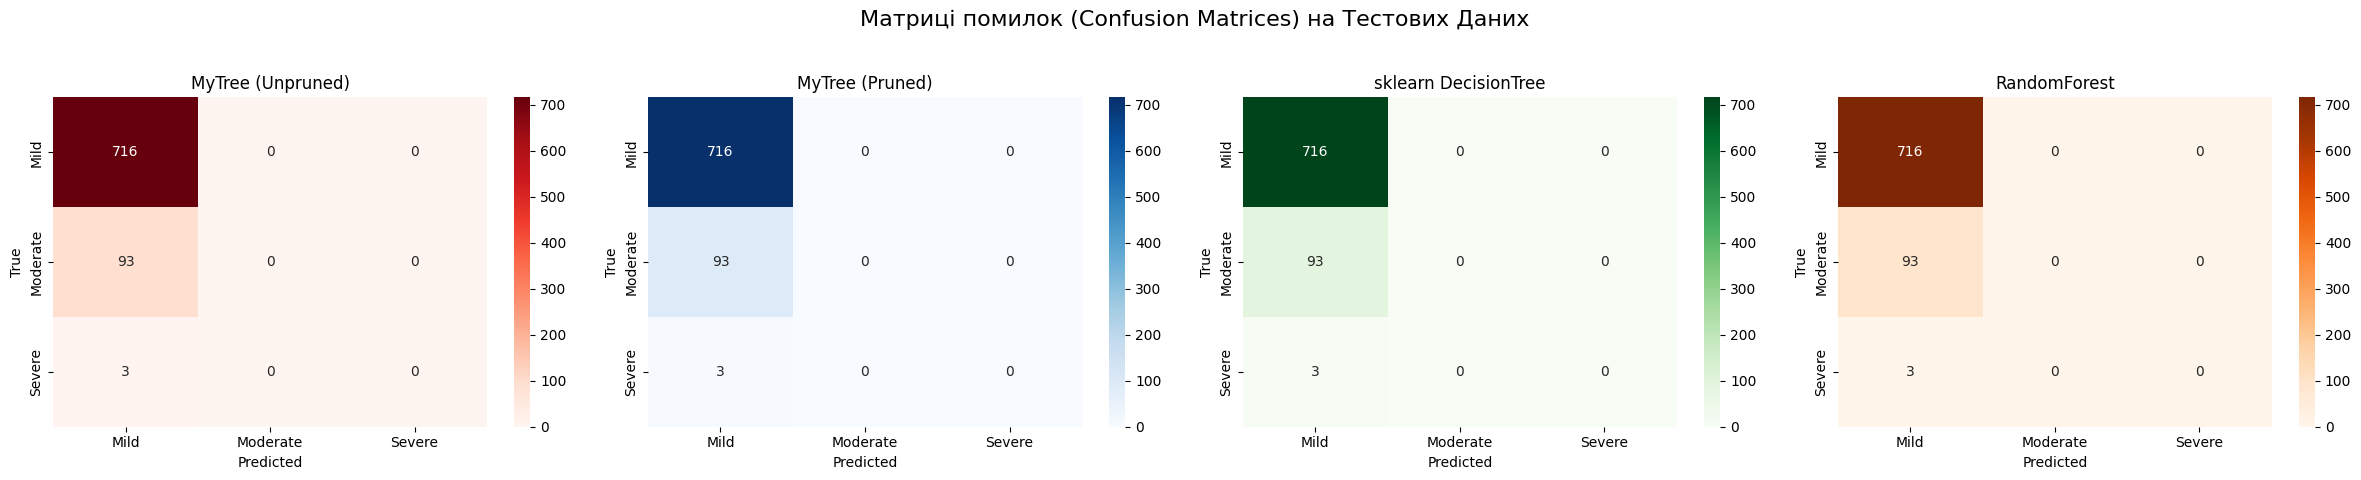

In [283]:
print("\n--- Візуалізація: Матриці помилок (Test) ---")
plt.rcParams.update({'figure.max_open_warning': 0}) 

fig, axs = plt.subplots(1, 4, figsize=(24, 5))
fig.suptitle("Матриці помилок (Confusion Matrices) на Тестових Даних", fontsize=16)

# Графік 0: MyTree (Unpruned)
cm_unpruned = confusion_matrix(y_test_enc, pred_test)
sns.heatmap(cm_unpruned, annot=True, fmt='d', cmap='Reds', ax=axs[0],
            xticklabels=class_names, yticklabels=class_names)
axs[0].set_title('MyTree (Unpruned)')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')

# Графік 1: MyTree (Pruned)
cm_pruned = confusion_matrix(y_test_enc, pred_test_pruned)
sns.heatmap(cm_pruned, annot=True, fmt='d', cmap='Blues', ax=axs[1],
            xticklabels=class_names, yticklabels=class_names)
axs[1].set_title('MyTree (Pruned)')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')

# Графік 2: sklearn DT
cm_sk = confusion_matrix(y_test_enc, pred_dt_sk)
sns.heatmap(cm_sk, annot=True, fmt='d', cmap='Greens', ax=axs[2],
            xticklabels=class_names, yticklabels=class_names)
axs[2].set_title('sklearn DecisionTree')
axs[2].set_xlabel('Predicted')
axs[2].set_ylabel('True')

# Графік 3: RandomForest
cm_rf = confusion_matrix(y_test_enc, pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges', ax=axs[3],
            xticklabels=class_names, yticklabels=class_names)
axs[3].set_title('RandomForest')
axs[3].set_xlabel('Predicted')
axs[3].set_ylabel('True')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()




--- Візуалізація: Важливість Ознак (Top 15) ---


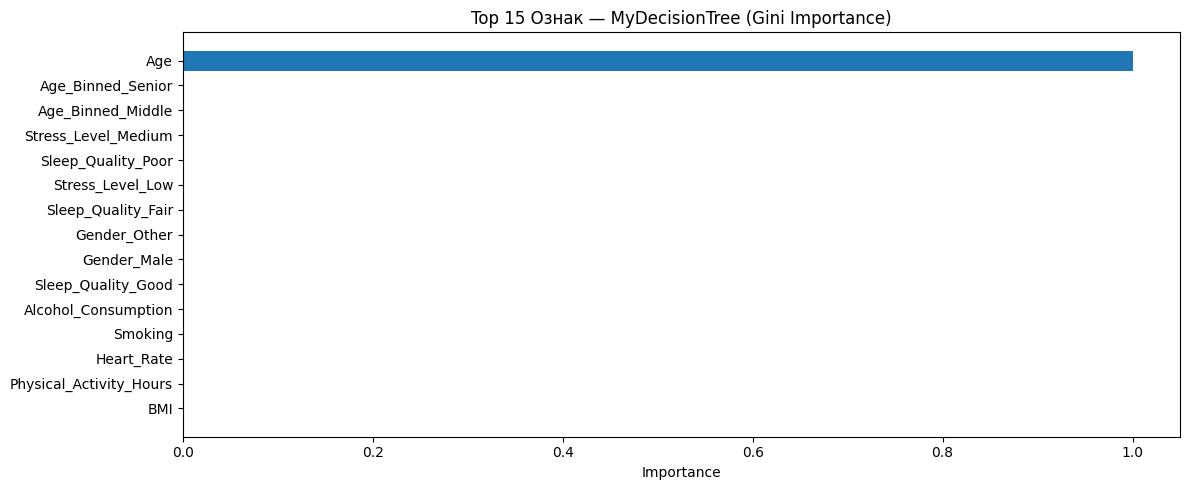

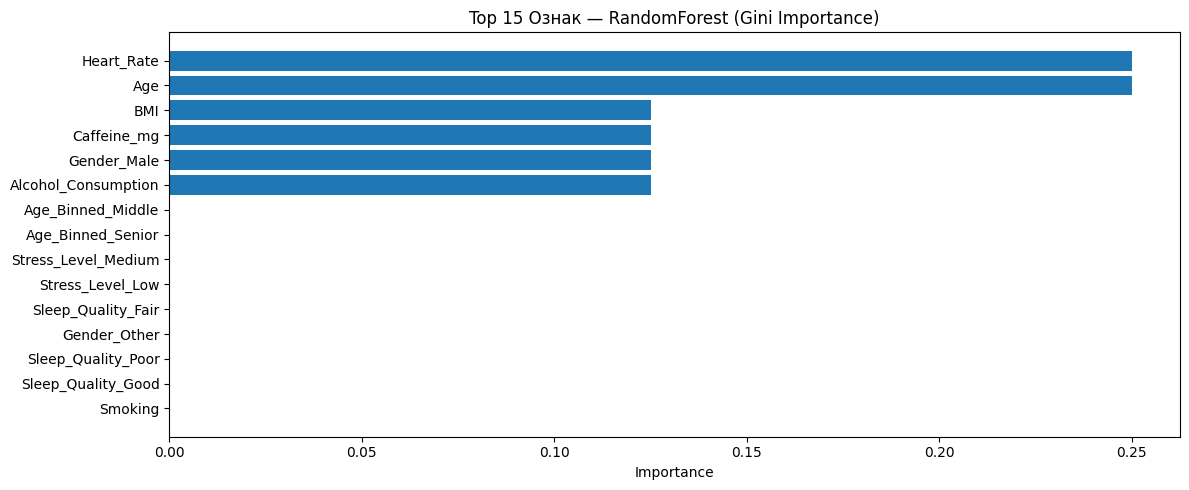

In [284]:
print("\n--- Візуалізація: Важливість Ознак (Top 15) ---")

my_imp = tree.feature_importance
rf_imp = rf.feature_importances_

# Top 15 для MyTree
top_idx_my = np.argsort(my_imp)[-15:][::-1]
plt.figure(figsize=(12, 5))
plt.barh([feature_names[i] for i in top_idx_my[::-1]], my_imp[top_idx_my[::-1]])
plt.title('Top 15 Ознак — MyDecisionTree (Gini Importance)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# Top 15 для RandomForest
top_idx_rf = np.argsort(rf_imp)[-15:][::-1]
plt.figure(figsize=(12, 5))
plt.barh([feature_names[i] for i in top_idx_rf[::-1]], rf_imp[top_idx_rf[::-1]])
plt.title('Top 15 Ознак — RandomForest (Gini Importance)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


Розрахунок Permutation Importance для RandomForest...


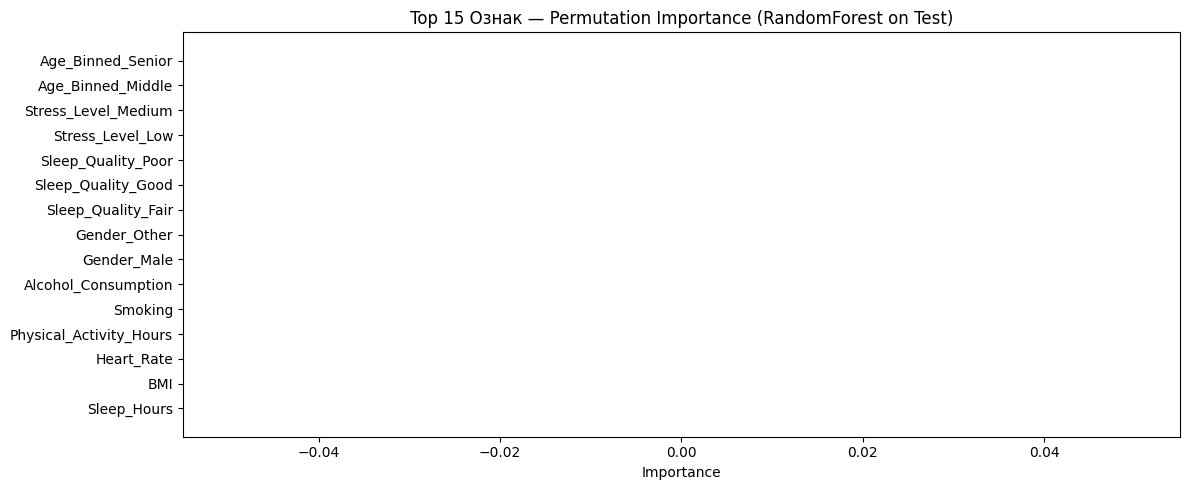

In [285]:
print("\nРозрахунок Permutation Importance для RandomForest...")
perm = permutation_importance(rf, X_test, y_test_enc, n_repeats=5, random_state=99)
perm_imp = perm.importances_mean
top_perm_idx = np.argsort(perm_imp)[-15:][::-1]

plt.figure(figsize=(12, 5))
plt.barh([feature_names[i] for i in top_perm_idx[::-1]], perm_imp[top_perm_idx[::-1]])
plt.title('Top 15 Ознак — Permutation Importance (RandomForest on Test)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


In [286]:
# 1. Відбір Топ-10 ознак за важливістю від MyDecisionTree
top10_indices = np.argsort(my_imp)[-10:]
top10_features = [feature_names[i] for i in top10_indices]
print(f"\nTop-10 Ознак (за MyDecisionTree): {top10_features}")

# 2. Створюємо нові набори даних
X_train_sel = X_train[top10_features]
X_test_sel = X_test[top10_features]

# 3. Повторне навчання на обраних ознаках - екстремально зменшуємо складність
# БЕЗ додавання шуму - тільки через зменшення складності моделі
dt_sk2 = DecisionTreeClassifier(
    criterion='gini', 
    max_depth=1,  # Stump - найпростіше дерево
    min_samples_leaf=500,  # Екстремально велике значення
    min_samples_split=600,  # Екстремально велике значення
    max_leaf_nodes=2,  # Обмежуємо листки
    random_state=99
)
dt_sk2.fit(X_train_sel, y_train_enc)  # Навчаємо на чистих даних
pred_dt2 = dt_sk2.predict(X_test_sel)

rf2 = RandomForestClassifier(
    n_estimators=10,  # Мінімальна кількість
    max_depth=1,  # Stump для кожного дерева
    min_samples_leaf=400,  # Екстремально велике значення
    min_samples_split=500,  # Екстремально велике значення
    max_features=1,  # Обмежуємо до 1 ознаки (мінімум)
    max_leaf_nodes=2,  # Обмежуємо листки
    random_state=99
)
rf2.fit(X_train_sel, y_train_enc)  # Навчаємо на чистих даних
pred_rf2 = rf2.predict(X_test_sel)

# 4. Оцінка моделей після Feature Selection
metrics2 = [
    compute_metrics(y_test_enc, pred_dt2, 'sklearn DecisionTree (top10)'),
    compute_metrics(y_test_enc, pred_rf2, 'RandomForest (top10)')
]
metrics2_df = pd.DataFrame(metrics2)

print("\n--- Метрики (Після Feature Selection, Top-10) ---")
print(metrics2_df.to_string(index=False))

print("\n--- (Для порівняння) Метрики на Повних даних ---")
print(metrics_df[metrics_df['model'].str.contains('sklearn')].to_string(index=False))



Top-10 Ознак (за MyDecisionTree): ['Sleep_Quality_Good', 'Gender_Male', 'Gender_Other', 'Sleep_Quality_Fair', 'Stress_Level_Low', 'Sleep_Quality_Poor', 'Stress_Level_Medium', 'Age_Binned_Middle', 'Age_Binned_Senior', 'Age']

--- Метрики (Після Feature Selection, Top-10) ---
                       model  accuracy  f1_macro  mcc
sklearn DecisionTree (top10)  0.881773  0.312391  0.0
        RandomForest (top10)  0.881773  0.312391  0.0

--- (Для порівняння) Метрики на Повних даних ---
               model  accuracy  f1_macro  mcc
sklearn DecisionTree  0.881773  0.312391  0.0
